# RFSoC-PYNQ Multi-Tile Sync Acquisition Design
---

This overlay requires the ZCU208, CLK104 and XM655 boards configured as described in the ["Common Board Setup"](./CommonBoardWiring.ipynb) page.  Please ensure your setup matches that configuration before proceeding.
<p align="center">
  <img src="./images/directConnections_DCblocks.JPG" width="60%" />
</p>
This overlay provides one DAC player memory that is broadcast to multiple RF DAC tiles. DACs in use are Tiles 228 and 229. Tile 230, while enabled, only shares the reference 4GHz to Tiles 228 and 229.  ADC tiles 224 and 225 capture to internal memories.  ADC tile 225 channel 1 stores to the PL DRAM via DMA.  A simplified block diagram is presented below.
<p align="center">
  <img src="./images/daqOverlay_simplifiedBlockDiagram.png" width="65%" />
</p>
<div class="alert alert-block alert-danger">Because of the clocking strategy used in this overlay it is best run after first power-cycling your board.</div>

In [1]:
from rfsoc_mts import mtsOverlay
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ol = mtsOverlay('mts.bit')

### Set the Active RF Tiles
This design uses two ADC Tiles labeled 0 and 1 which map to Banks 224 and 225.  The two DAC tiles in use, 0 and 1, map to Banks 228 and 229.  While DAC Bank 230 is enabled, its purpose is to distribute a reference clock to the adjacent DAC tiles. 

In [3]:
ACTIVE_DAC_TILES = 0b0011  # These bit vectors set the tiles 1 and 0
ACTIVE_ADC_TILES = 0b0011  # based on their bit position

# Generate Waveforms for Loopback
 This overlay uses a single waveform memory that is broadcast to multiple DAC tiles.
### Prepare the DAC Memory
The cell below generates examples waveforms and has customizable paramters.  For example, one can adjust the center frequency, Fc, and re-generate a sinewave.

In [4]:
from scipy.signal import chirp
from scipy.signal import sawtooth
from scipy.signal import gausspulse

DAC_SR = 4.0E9  # Sample rate of DACs and ADCs is 4.0 GHz
ADC_SR = 4.0E9
Fc = 250.0E6 # Set center frequency of waveform to 250.0 MHz
Fe = 800.0E6 # maximum frequency of chirp at end of record
DAC_Amplitude = 16383.0 # 14bit DAC +16383/-16384
X_axis = (1/DAC_SR) * np.arange(0,ol.dac_player.shape[0])

In [5]:
# generate some basic waveforms
DAC_sinewave = DAC_Amplitude * np.sin(2*np.pi*Fc*X_axis)
DAC_sawtooth = DAC_Amplitude * sawtooth(2 * np.pi * Fc * X_axis)
DAC_chirp = DAC_Amplitude * chirp(np.arange(0, ol.dac_player.shape[0])/DAC_SR,
                                  f0=Fc, f1=Fe, t1=(ol.dac_player.shape[0]/DAC_SR), 
                                  phi=0.0, method='linear')

In [6]:
ol.dac_player[:] = np.int16(DAC_sinewave)
#ol.dac_player[:] = np.int16(DAC_sawtooth)
#ol.dac_player[:] = np.int16(DAC_chirp)

---

## Capture DAC Waveform to Internal Memory
The DAC waveform is saved to an internal memory for verification purposes.

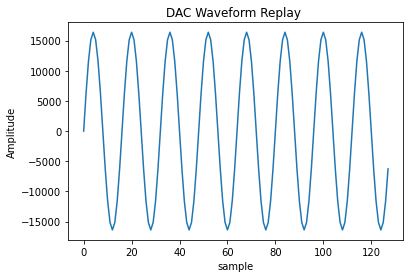

In [7]:
ol.trigger_capture()
pNumSamples = 128
plt.title('DAC Waveform Replay ')
plt.xlabel('sample')         
plt.ylabel('Amplitude')
plt.plot(ol.dac_capture[0:pNumSamples])
plt.show()
# Note that the waveform is NOT aligned to sample zero of the DACRAM as it is free-running

---

# Non-Aligned ADC Capture and Analysis
Without MTS enabled, the DAC output and ADC samples captured are not phase-aligned.  For this experiment, MTS is not enabled and results captured.
Also, an array is defined to capture the non-aligned data.

But first we define some helper plotting functions...

In [8]:
def stemplot(sample_list, pStart=0, pNumSamples=16):
    plt.stem(sample_list[0][pStart:(pStart+pNumSamples)])
    plt.stem(sample_list[1][pStart:(pStart+pNumSamples)], linefmt='r:', markerfmt='rx')
    plt.stem(sample_list[2][pStart:(pStart+pNumSamples)], linefmt='g-', markerfmt='g+')
    plt.tight_layout()
    return plt

def gridplot(sample_list, pStart=0, pNumSamples=128):
    plt.subplots(3,1)
    plt.subplot(311)
    plt.plot(sample_list[0][pStart:(pStart+pNumSamples)])
    plt.subplot(312)
    plt.plot(sample_list[1][pStart:(pStart+pNumSamples)])
    plt.subplot(313)
    plt.plot(sample_list[2][pStart:(pStart+pNumSamples)])
    plt.tight_layout()
    return plt

In [9]:
ol.init_tile_sync()
nonAlignedCaptureSamples = np.zeros((3,len(ol.adc_capture_chA)),dtype=np.int16)
ol.verify_clock_tree()

In [10]:
ol.internal_capture(nonAlignedCaptureSamples)

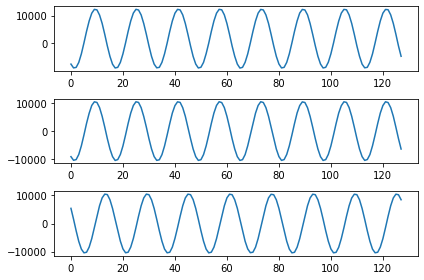

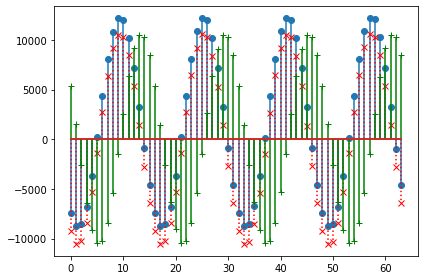

In [11]:
gridplot(nonAlignedCaptureSamples, pStart=0, pNumSamples=128).show()
stemplot(nonAlignedCaptureSamples, pStart=0, pNumSamples=64).show()

# Analysis of the Non-Aligned Captured Waveforms
The outputs should appear out of phase with respect to one another despite driven from a common DAC waveform memory.

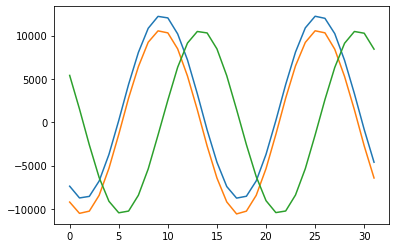

In [12]:
pStart = 0
pNumSamples = 32
plt.plot(nonAlignedCaptureSamples[0][pStart:(pStart+pNumSamples)])
plt.plot(nonAlignedCaptureSamples[1][pStart:(pStart+pNumSamples)])
plt.plot(nonAlignedCaptureSamples[2][pStart:(pStart+pNumSamples)])
plt.show()

---

# Enable Multi-Tile Synchronization - MTS
With Multi-Tile Synchronization enabled the DAC output and ADC samples are aligned.  This feature of the RFSOC allows coherency across DAC and ADC tiles.  The RF tiles are reset and their internal FIFOs reset via "init_tile_sync" while also testing if the synthesizer clocks are ready.  Once initialized, the "sync_tiles" function begins the synchronization procedure of the tiles. The results are analyzed below.

In [13]:
ol.init_tile_sync(dacTiles = ACTIVE_DAC_TILES, adcTiles = ACTIVE_ADC_TILES)
ol.verify_clock_tree()

In [14]:
ol.sync_tiles(dacTiles = ACTIVE_DAC_TILES, adcTiles = ACTIVE_ADC_TILES)
AlignedCaptureSamples = np.zeros((3,len(ol.adc_capture_chA)),dtype=np.int16)

In [15]:
ol.internal_capture(AlignedCaptureSamples)

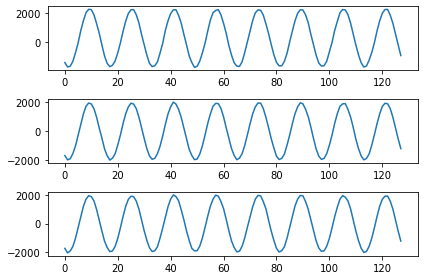

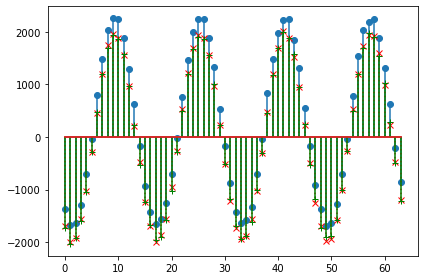

In [16]:
gridplot(AlignedCaptureSamples, pStart=0, pNumSamples=128).show()
stemplot(AlignedCaptureSamples, pStart=0, pNumSamples=64).show()

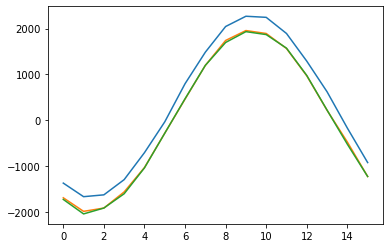

In [17]:
pStart = 0
pNumSamples = 16
plt.plot(AlignedCaptureSamples[0][pStart:(pStart+pNumSamples)])
plt.plot(AlignedCaptureSamples[1][pStart:(pStart+pNumSamples)])
plt.plot(AlignedCaptureSamples[2][pStart:(pStart+pNumSamples)])
plt.show()

## Latency Incurred Due To Alignment
Enabling MTS adds additional latency in the received sample datapath.  Due to the alignment process one or more streams will be delayed N number of samples and that is reported below in the "Latency Reporting".

In [18]:
print("Latency DAC Tile 0: ", ol.xrfdc.mts_dac_config.Latency[0])
print("Latency DAC Tile 1: ", ol.xrfdc.mts_dac_config.Latency[1])
print("Latency ADC Tile 0: ", ol.xrfdc.mts_adc_config.Latency[0])
print("Latency ADC Tile 1: ", ol.xrfdc.mts_adc_config.Latency[1])

Latency DAC Tile 0:  112
Latency DAC Tile 1:  112
Latency ADC Tile 0:  96
Latency ADC Tile 1:  96


## Verify Alignment Stability
Perform the correlation of the two non-adjacent channels and verify the sinewaves are in alignment

In [19]:
from scipy import signal

iterations = 32
for i in range(iterations):
    ol.internal_capture(AlignedCaptureSamples)
    N = len(AlignedCaptureSamples[0])  # choose power of two for efficiency
    Tile0 = AlignedCaptureSamples[0][:N]/2**15
    TileN = AlignedCaptureSamples[2][:N]/2**15
    x_corr = signal.fftconvolve(TileN, Tile0[::-1], mode='full')  # compute the cross corrleation of non-adjacent channels
    lag0 = np.argmax(x_corr)
    if (lag0 != (N-1)):
        print("Failed at ", i, " : MTS Alignment is not stable - please power-cycle board and verify CLK104 and board connections...")
        pStart = 0
        pNumSamples = 16
        plt.plot(AlignedCaptureSamples[0][pStart:(pStart+pNumSamples)])
        plt.plot(AlignedCaptureSamples[2][pStart:(pStart+pNumSamples)])
        plt.show()
        break
print("MTS Successful")

MTS Successful


---

# Deep Capture to PL DDR4 Memory
The ZCU208 has an additional DRAM exclusively for the PL.  Specifically, this overlay stores ADC Tile 225 - channel 1 samples. Our overlay limits a DMA descriptor to a maximum length of 24bit or 16MB.

In [20]:
from pynq import allocate
numSamplesPerDMA = (8 << 20)-1 # 8 MSample = 16MB
dbuf = allocate(numSamplesPerDMA, dtype=np.int16, target=ol.ddr4_0)

In [21]:
ol.dram_capture(dbuf)

## Plot Captured ADC Samples from PL DRAM
The DMA interface captures 2MB worth of sample data and saved it into PL DRAM.  Each sample is 2 bytes each (int16) and we have allocated one mega-sample.

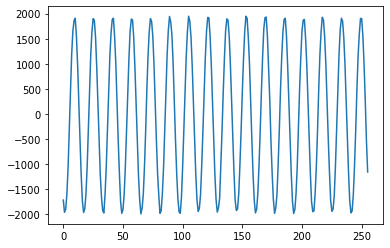

In [22]:
pStart = (1<<10)*512
pNumSamples = 256
plt.plot(ol.ADCdeepcapture[pStart:(pStart+pNumSamples)])
plt.show()

In [23]:
dbuf.freebuffer() # reclaim memory

## Verify Waveform Properties Match Expectations

If the DAC waveform was a sinewave, verify the captured ADC waveform is sinusoidal.  If a chirp, verify linear frequency ramping of the captured signal or plot the magnitude of the FFT.  Return to earlier cells and try different waveform generation functions and observe the captured ADC samples to the deep memory.  The DMA interface is limited to a maximum of 16MB per descriptor, so it is not feasible to attempt writing the entire DRAM.  One can modify the cells above to target different regions of the DRAM and deposit more sample sets for analysis.